# Forward Rate Analysis

## 1.1 Bootstrap Spot Curve

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Bootstrap Methodology

### No-Arbitrage Pricing

For a bond with cashflows $C_1, C_2, \ldots, C_n$ at times $t_1, t_2, \ldots, t_n$:

$$P_{dirty} = \sum_{i=1}^{n} C_i \cdot Z(t_i)$$

### Sequential Solution

Given bonds with increasing maturities $T_1 < T_2 < \cdots < T_N$:

$$Z(T_k) = \frac{P_k - \sum_{t_i < T_k} C_{k,i} \cdot Z(t_i)}{C_{k,n_k}}$$

where known discount factors $Z(t_i)$ for $t_i < T_k$ are used to isolate $Z(T_k)$.

### Rate Conversions

**Semiannually compounded:**
$$r_{sa}(t) = 2\left[Z(t)^{-1/(2t)} - 1\right]$$

**Continuously compounded:**
$$r_c(t) = -\frac{\ln Z(t)}{t}$$

In [2]:
# Load and prepare data
data = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name='quotes')
data[['quote date', 'issue date', 'maturity date']] = data[['quote date', 'issue date', 'maturity date']].apply(pd.to_datetime)
quote_date = data['quote date'].iloc[0]
data_clean = data.dropna(subset=['ytm', 'price']).query('ytm >= 0').copy()
data_clean['ttm_calc'] = (data_clean['maturity date'] - quote_date).dt.days / 365.25

# Select bonds at ~6-month intervals
max_maturity = int(np.ceil(data_clean['ttm_calc'].max()))
target_maturities = np.arange(0.5, max_maturity + 0.5, 0.5)
selected_bonds = []
for target in target_maturities:
    closest_idx = np.abs(data_clean['ttm_calc'] - target).idxmin()
    if closest_idx not in selected_bonds:
        selected_bonds.append(closest_idx)
bootstrap_bonds = data_clean.loc[selected_bonds].sort_values('ttm_calc').copy()

# Bootstrap algorithm
discount_factors = {}
for idx, bond in bootstrap_bonds.iterrows():
    dirty_price = bond['dirty price']
    coupon_pmt = bond['cpn rate'] / 2
    
    cashflow_dates = pd.date_range(start=bond['issue date'], end=bond['maturity date'], freq='6MS')
    if len(cashflow_dates) == 0 or cashflow_dates[-1] != bond['maturity date']:
        cashflow_dates = cashflow_dates.append(pd.DatetimeIndex([bond['maturity date']]))
    cashflow_dates = cashflow_dates[cashflow_dates > quote_date]
    
    pv_known = sum(coupon_pmt * discount_factors[cf_date] 
                   for cf_date in cashflow_dates[:-1] 
                   if cf_date in discount_factors)
    
    Z = (dirty_price - pv_known) / (coupon_pmt + 100)
    discount_factors[cashflow_dates[-1]] = Z

# Create spot curve DataFrame
spot_curve = pd.DataFrame([
    {'date': date, 'discount_factor': Z, 'ttm': (date - quote_date).days / 365.25}
    for date, Z in discount_factors.items()
]).sort_values('ttm')

spot_curve['rate_sa'] = 2 * (spot_curve['discount_factor']**(-1/(2*spot_curve['ttm'])) - 1)
spot_curve['rate_cc'] = -np.log(spot_curve['discount_factor']) / spot_curve['ttm']

## Results for T = 5 Years

In [3]:
# Find closest to T=5
t5_data = spot_curve.iloc[(spot_curve['ttm'] - 5.0).abs().argsort()[0]]

print(f"T = {t5_data['ttm']:.4f} years")
print(f"Discount Factor:             {t5_data['discount_factor']:.4f}")
print(f"Semiannual Rate:             {t5_data['rate_sa']:.4f}")
print(f"Continuous Rate:             {t5_data['rate_cc']:.4f}")

T = 5.0048 years
Discount Factor:             1.0334
Semiannual Rate:             -0.0066
Continuous Rate:             -0.0066


## 1.2 Forward Discount Factors

### Forward Rate Definition

The **forward discount factor** from time $T$ to $T + \Delta$ is:

$$F(0, T, T+\Delta) = \frac{Z(0, T+\Delta)}{Z(0, T)}$$

This represents the price today for a zero-coupon bond that pays \$1 at time $T+\Delta$, delivered at time $T$.

### Forward Rate Conversions

For a $\Delta = 0.5$ year forward period:

**Semiannually compounded forward rate:**
$$F = \left(1 + \frac{f_{sa}}{2}\right)^{-1} \quad \Rightarrow \quad f_{sa} = 2\left(\frac{1}{F} - 1\right)$$

**Continuously compounded forward rate:**
$$F = e^{-f_c \cdot \Delta} \quad \Rightarrow \quad f_c = -\frac{\ln F}{\Delta}$$

### Economic Interpretation

The forward rate $f(0, T, T+\Delta)$ is the **break-even rate** for:
- Investing from 0 to $T+\Delta$ at spot rate $r(T+\Delta)$, versus
- Investing from 0 to $T$ at spot rate $r(T)$, then reinvesting from $T$ to $T+\Delta$ at $f$

No-arbitrage requires:
$$Z(0,T) \cdot F(0,T,T+\Delta) = Z(0,T+\Delta)$$

In [4]:
# Calculate 6-month forward rates
forward_data = []
for i in range(len(spot_curve) - 1):
    T1, T2 = spot_curve.iloc[i]['ttm'], spot_curve.iloc[i + 1]['ttm']
    if abs(T2 - T1 - 0.5) < 0.1:
        Z_T1, Z_T2 = spot_curve.iloc[i]['discount_factor'], spot_curve.iloc[i + 1]['discount_factor']
        F = Z_T2 / Z_T1
        forward_data.append({
            'T': T1,
            'forward_discount': F,
            'forward_rate_sa': 2 * (1/F - 1),
            'forward_rate_cc': -np.log(F) / 0.5
        })

forward_df = pd.DataFrame(forward_data)
print("6-Month Forward Rates:")
display(forward_df)

6-Month Forward Rates:


,T,forward_discount,forward_rate_sa,forward_rate_cc
0,0.503765,0.973230,0.055014,0.054271
1,0.996578,1.040432,-0.077722,-0.079272
2,1.503080,0.976886,0.047321,0.046770
3,2.004107,0.965324,0.071843,0.070583
4,2.505133,1.080977,-0.149822,-0.155730
5,3.006160,0.952134,0.100545,0.098099
6,3.504449,1.037544,-0.072372,-0.073714
7,4.005476,1.005572,-0.011082,-0.011112
8,4.503765,1.016149,-0.031785,-0.032041
9,5.004791,1.012545,-0.024780,-0.024935


## Results for T = 5 to T = 5.5

In [5]:
# Find T=5 to T=5.5 forward rate
t5_forward = forward_df[forward_df['T'].between(4.9, 5.1)]
if len(t5_forward) > 0:
    row = t5_forward.iloc[0]
    print(f"T = {row['T']:.4f} to {row['T'] + 0.5:.4f}")
    print(f"Forward Discount Factor:     {row['forward_discount']:.4f}")
    print(f"Forward Rate (Semiannual):   {row['forward_rate_sa']:.4f}")
    print(f"Forward Rate (Continuous):   {row['forward_rate_cc']:.4f}")

T = 5.0048 to 5.5048
Forward Discount Factor:     1.0125
Forward Rate (Semiannual):   -0.0248
Forward Rate (Continuous):   -0.0249


## 1.3 Forward Curve Analysis

### Relationship Between Forward Rates and Spot Curve Slope

The **instantaneous forward rate** at maturity $T$ relates to the spot rate via:

$$f(0,T) = r(T) + T \cdot \frac{dr(T)}{dT}$$

This yields three key relationships:

| Condition | Spot Curve Slope | Interpretation |
|-----------|-----------------|----------------|
| $f(T) > r(T)$ | $\frac{dr}{dT} > 0$ | **Upward sloping** (normal curve) |
| $f(T) = r(T)$ | $\frac{dr}{dT} = 0$ | **Flat** curve |
| $f(T) < r(T)$ | $\frac{dr}{dT} < 0$ | **Downward sloping** (inverted) |

### Economic Intuition

- **Forward > Spot**: Market expects rising rates → spot curve must increase to reflect higher future borrowing costs
- **Forward < Spot**: Market expects falling rates → spot curve must decrease to reflect lower future borrowing costs

### Mathematical Derivation

From the no-arbitrage condition:
$$Z(0,T+\Delta) = Z(0,T) \cdot e^{-f(0,T) \cdot \Delta}$$

Taking logs and differentiating:
$$-r(T+\Delta)(T+\Delta) = -r(T) \cdot T - f(0,T) \cdot \Delta$$

As $\Delta \to 0$:
$$f(0,T) = \frac{d}{dT}[T \cdot r(T)] = r(T) + T \cdot \frac{dr(T)}{dT}$$

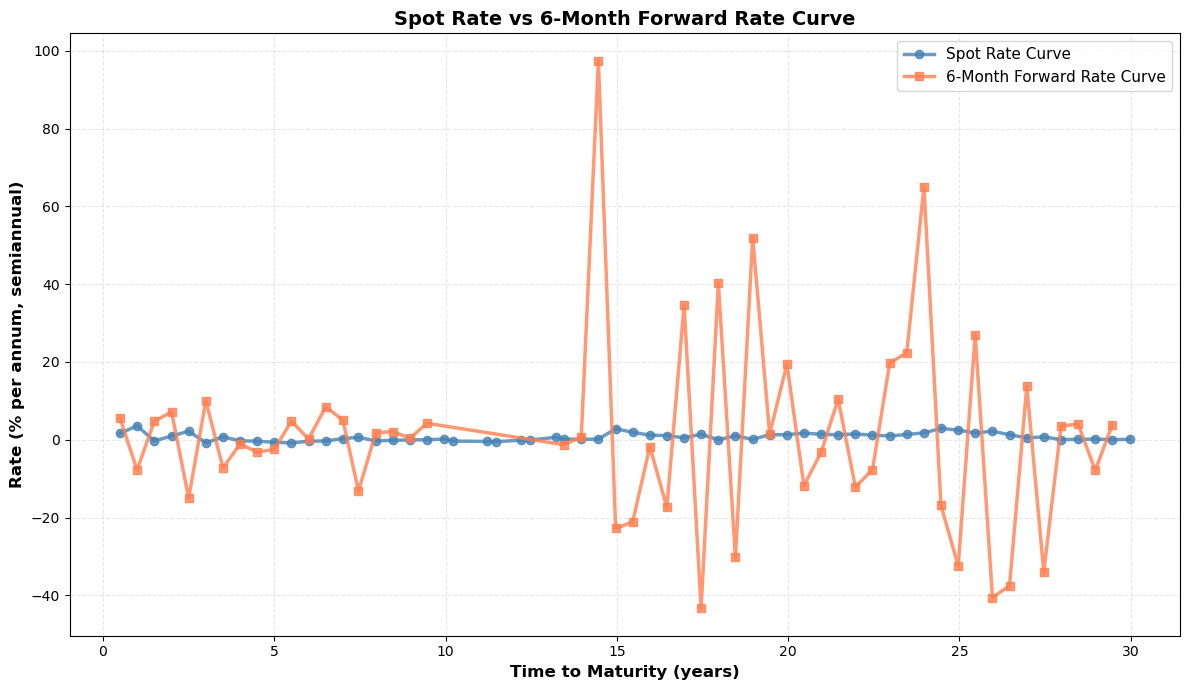

In [6]:
# Plot spot and forward curves
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(spot_curve['ttm'], spot_curve['rate_sa'] * 100, 
        'o-', linewidth=2.5, markersize=6, color='steelblue', 
        label='Spot Rate Curve', alpha=0.8)
ax.plot(forward_df['T'], forward_df['forward_rate_sa'] * 100, 
        's-', linewidth=2.5, markersize=6, color='coral', 
        label='6-Month Forward Rate Curve', alpha=0.8)

ax.set_xlabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Rate (% per annum, semiannual)', fontsize=12, fontweight='bold')
ax.set_title('Spot Rate vs 6-Month Forward Rate Curve', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Maximum Forward Rate Analysis

In [7]:
# Find maximum forward rate
max_idx = forward_df['forward_rate_sa'].idxmax()
max_row = forward_df.loc[max_idx]

print(f"Maximum Forward Rate:")
print(f"Maturity Interval: T = {max_row['T']:.4f} to T = {max_row['T'] + 0.5:.4f}")
print(f"Forward Rate (SA): {max_row['forward_rate_sa']:.4f} ({max_row['forward_rate_sa']*100:.4f}%)")

Maximum Forward Rate:
Maturity Interval: T = 14.4613 to T = 14.9613
Forward Rate (SA): 0.9745 (97.4485%)


## Spot Curve Slope Analysis

In [8]:
# Compare forward rates to spot rates
comparison = []
for i, fwd_row in forward_df.iterrows():
    T_start = fwd_row['T']
    spot_row = spot_curve.iloc[(spot_curve['ttm'] - T_start).abs().argsort()[0]]
    comparison.append({
        'T': T_start,
        'forward_rate': fwd_row['forward_rate_sa'],
        'spot_rate': spot_row['rate_sa'],
        'difference_bps': (fwd_row['forward_rate_sa'] - spot_row['rate_sa']) * 10000,
        'slope': 'Upward' if fwd_row['forward_rate_sa'] > spot_row['rate_sa'] else 'Downward'
    })

comparison_df = pd.DataFrame(comparison)
display(comparison_df)

upward_count = (comparison_df['slope'] == 'Upward').sum()
downward_count = (comparison_df['slope'] == 'Downward').sum()

print(f"\nSpot curve is upward sloping at {upward_count} maturities")
print(f"Spot curve is downward sloping at {downward_count} maturities")

,T,forward_rate,spot_rate,difference_bps,slope
0,0.503765,0.055014,0.016298,387.157407,Upward
1,0.996578,-0.077722,0.035749,-1134.711685,Downward
2,1.503080,0.047321,-0.002875,501.956568,Upward
3,2.004107,0.071843,0.009534,623.091771,Upward
4,2.505133,-0.149822,0.021815,-1716.360995,Downward
5,3.006160,0.100545,-0.007806,1083.513759,Upward
6,3.504449,-0.072372,0.007300,-796.721054,Downward
7,4.005476,-0.011082,-0.002824,-82.574638,Downward
8,4.503765,-0.031785,-0.003744,-280.419235,Downward
9,5.004791,-0.024780,-0.006562,-182.178743,Downward



Spot curve is upward sloping at 28 maturities
Spot curve is downward sloping at 24 maturities


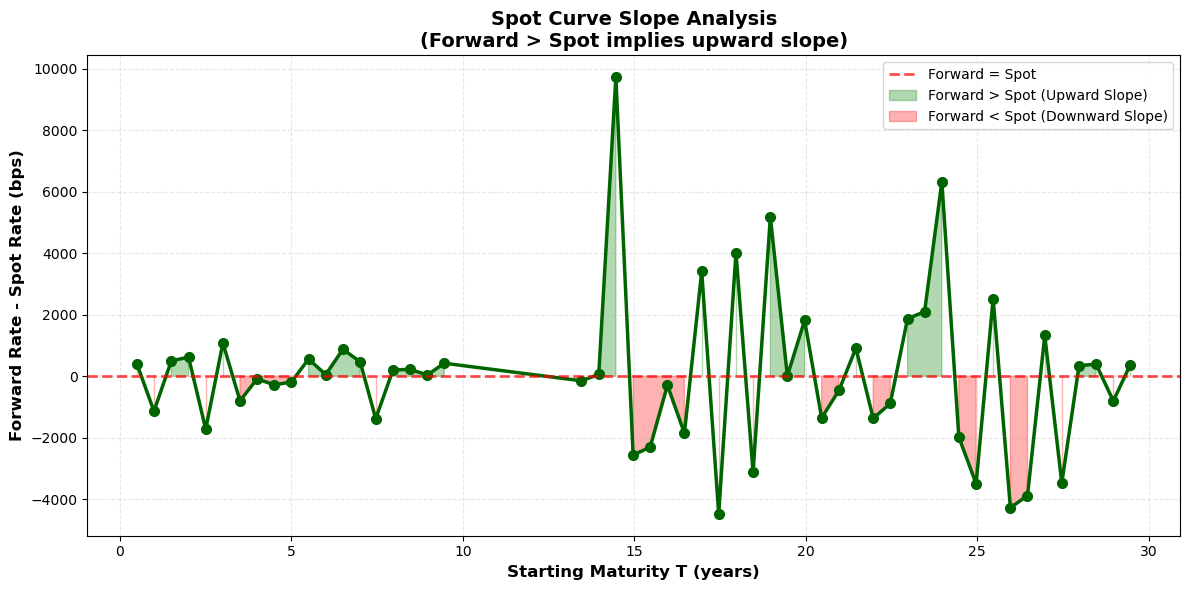

In [9]:
# Plot difference to visualize slope
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(comparison_df['T'], comparison_df['difference_bps'], 
        'o-', linewidth=2.5, markersize=7, color='darkgreen')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Forward = Spot')
ax.fill_between(comparison_df['T'], 0, comparison_df['difference_bps'], 
                where=(comparison_df['difference_bps'] > 0), alpha=0.3, color='green', 
                label='Forward > Spot (Upward Slope)')
ax.fill_between(comparison_df['T'], 0, comparison_df['difference_bps'], 
                where=(comparison_df['difference_bps'] <= 0), alpha=0.3, color='red', 
                label='Forward < Spot (Downward Slope)')

ax.set_xlabel('Starting Maturity T (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Forward Rate - Spot Rate (bps)', fontsize=12, fontweight='bold')
ax.set_title('Spot Curve Slope Analysis\n(Forward > Spot implies upward slope)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()